# Results

*Team: nada401*

In this Notebook we present the initial results of our project.<br>
While here are presented the most interesting results, more in-depth analysis have been conducted and the respective files are stored in:

`./src/scripts`

Structure of the Notebook:
- Data cleaning and exploration
    - Language tagging
    - Data cleaning
    - Data exploration
- Expert-metric
    - Ad-hoc metric
    - Semantic Richness
    - Embeddings

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Reproducibility

To reproduce the results of this notebook first download the datasets from [here](https://drive.google.com/drive/folders/1Wz6D2FM25ydFw_-41I9uTwG9uNsN4TCF) and unzip them in `./data/`.

Only the datasets
- `RateBeer`
- `BeerAdvocate`

are used for this part of the project.

### Notation

To distinguish the two datasets, a common naming scheme has been used, in particular:
- `*_RB` contains data from RateBeer
- `*_BA` contains data from BeerAdvocate

## Data cleaning and exploration

The first step into developing this project is cleaning and exploring the data.

### Language tagging

A first manual analysis of the datasets revealed that some reviews have been written in different languages, so we first wanted to understand the share of each language to direct our successive steps.

To achieve this, we tested different python packages that tag language, among which:
- [fast_langdetect](https://github.com/LlmKira/fast-langdetect)
- [langdetect](https://pypi.org/project/langdetect/)
- [lingua](https://github.com/pemistahl/lingua-py)

Finally opting for the first, being the fastest and having good precision.

In [ ]:
from src.scripts.lang_tagger import lang_tagger

'''
Execute the language tagging process.
This function calls the pipeline that reads the .txt.gz files and creates a .csv file
with only the reviews and few other columns for indexing purposes.
'''
lang_tagger.tag_datasets()

In [3]:
d_BA = pd.read_csv("./data/BeerAdvocate/reviews_tagged.csv")
d_RB = pd.read_csv("./data/RateBeer/reviews_tagged.csv")

eng_perc_BA = d_BA["lang_tag"].value_counts()['en']/d_BA["lang_tag"].count() * 100
eng_perc_RB = d_RB["lang_tag"].value_counts()['en']/d_RB["lang_tag"].count() * 100

print(f"Percentage of English reviews in BeerAdvocate = {eng_perc_BA:.3f}%")
print(f"Percentage of English reviews in RateBeer = {eng_perc_RB:.3f}%")

print(f"\nNumber of reviews for the first 5 most used languages in RateBeer. Only the first 5 shown for visualization purposes")
print(f"{d_RB['lang_tag'].value_counts()[:5]}")

Percentage of English reviews in BeerAdvocate = 99.975%
Percentage of English reviews in RateBeer = 92.844%

Number of reviews for the first 5 most used languages in RateBeer. Only the first 5 shown for visualization purposes
lang_tag
en    6606969
pl     104950
fr      99688
de      73328
nl      36357
Name: count, dtype: int64


The majority of reviews are made in English, especially in BeerAdvocate. 
We therefore initially focus on solely English reviews, specifically the one in BeerAdvocate, but we plan later in the development of the project to work also on RateBeer and we to test our metrics on different languages as well.

In [4]:
# Free memory after showing the results
del d_BA, d_RB

### Data cleaning

The dataset contained various NaN values and duplicated rows, all of which must be properly handled to ensure a correct analysis.

In [5]:
from src.scripts.data_cleaning import data_cleaning, load_file

'''
Load the datasets and clean them. In particular:
- drop duplicates
- treat NaNs
- delete beers that don't have reviews
- delete users that didn't review at least one beer
- add language_tag column to the datasets
'''
data_cleaning.clean_data('./data')

In [6]:
 # Issues with users.csv
df_users_RB = pd.read_csv('./data/RateBeer/users.csv')
df_users_RB_clean = pd.read_csv('./data/RateBeer/users_RB_clean.csv')

print(f"Are users_id in BeerAdvocate's user dataframe unique? {df_users_RB['user_id'].is_unique}")
print(f"By removing users that never did written reviews we dropped {df_users_RB.shape[0] - df_users_RB_clean.shape[0]} rows")
print(f"Rows before cleaning: {df_users_RB.shape[0]}\nRows after cleaning:  {df_users_RB_clean.shape[0]}")

Are users_id in BeerAdvocate's user dataframe unique? False
By removing users that never did written reviews we dropped 57 rows
Rows before cleaning: 70174
Rows after cleaning:  70117


In [7]:
# language tagging and formatting
df_ratings_BA_clean = pd.read_csv('./data/BeerAdvocate/ratings_BA_clean.csv', nrows=5)
df_ratings_BA_clean.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,lang_tag
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",True,en
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2009-02-20,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...,True,en
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2006-03-13,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim.....",True,en
3,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2004-12-01,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Serving: 500ml brown bottlePour: Good head wit...,True,en
4,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2004-08-30,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,"500ml bottlePours with a light, slightly hazy ...",True,en


In [ ]:
# Free memory after showing the results
del df_users_RB, df_users_RB_clean, df_ratings_BA_clean

### Data exploration

Extensive data exploration has been conducted to understand our datasets and guide our initial steps in the project.

This involved extrapolating interesting statistics from the data.<br>
The extensive process is shown in the notebook:

`./src/scripts/EDA/ADA_Beers.ipynb`

We will now show interesting results from our exploratory data analysis.

In [9]:
path_BA = './data/BeerAdvocate'
path_RB = './data/RateBeer'

users_RB = pd.read_csv(os.path.join(path_RB, 'users.csv'))
users_BA = pd.read_csv(os.path.join(path_BA, 'users.csv'))

Text(0, 0.5, 'Number of Users')

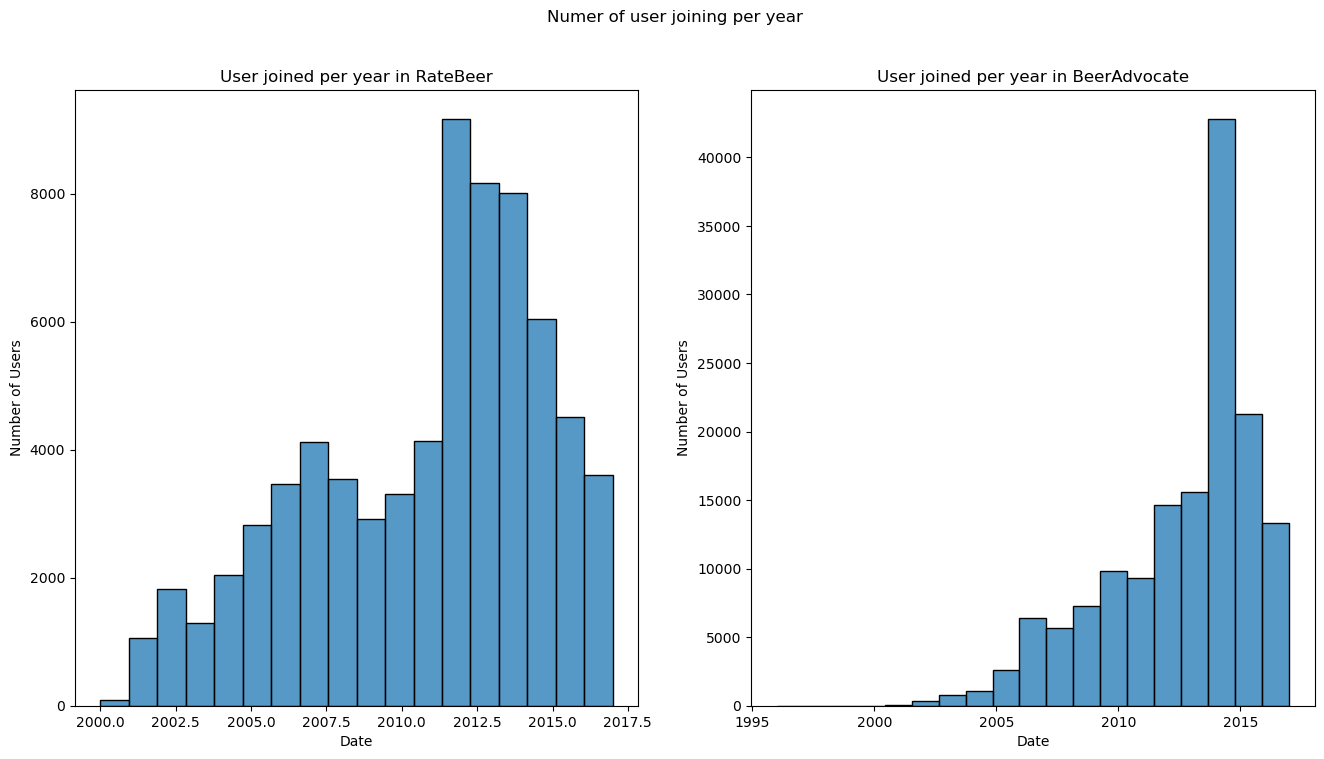

In [10]:
users_RB['joined'] = pd.to_datetime(users_RB['joined'], unit='s')
users_BA['joined'] = pd.to_datetime(users_BA['joined'], unit='s')

data_RB = users_RB["joined"].groupby([users_RB["joined"].dt.year]).count()
data_BA = users_BA["joined"].groupby([users_BA["joined"].dt.year]).count()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Numer of user joining per year')

sns.histplot(x=data_RB.index, weights=data_RB.values, bins=len(data_RB), ax=axes[0])
axes[0].set_title('User joined per year in RateBeer')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Users')

sns.histplot(x=data_BA.index, weights=data_BA.values, bins=len(data_BA), ax=axes[1])
axes[1].set_title('User joined per year in BeerAdvocate')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Users')

#### Styles of beers

This analysis helps us understanding specific beer styles that have a significant number of reviews. This might be helpful later to focus our efforts to tailor our "expert metric" to the most relevant beer styles.

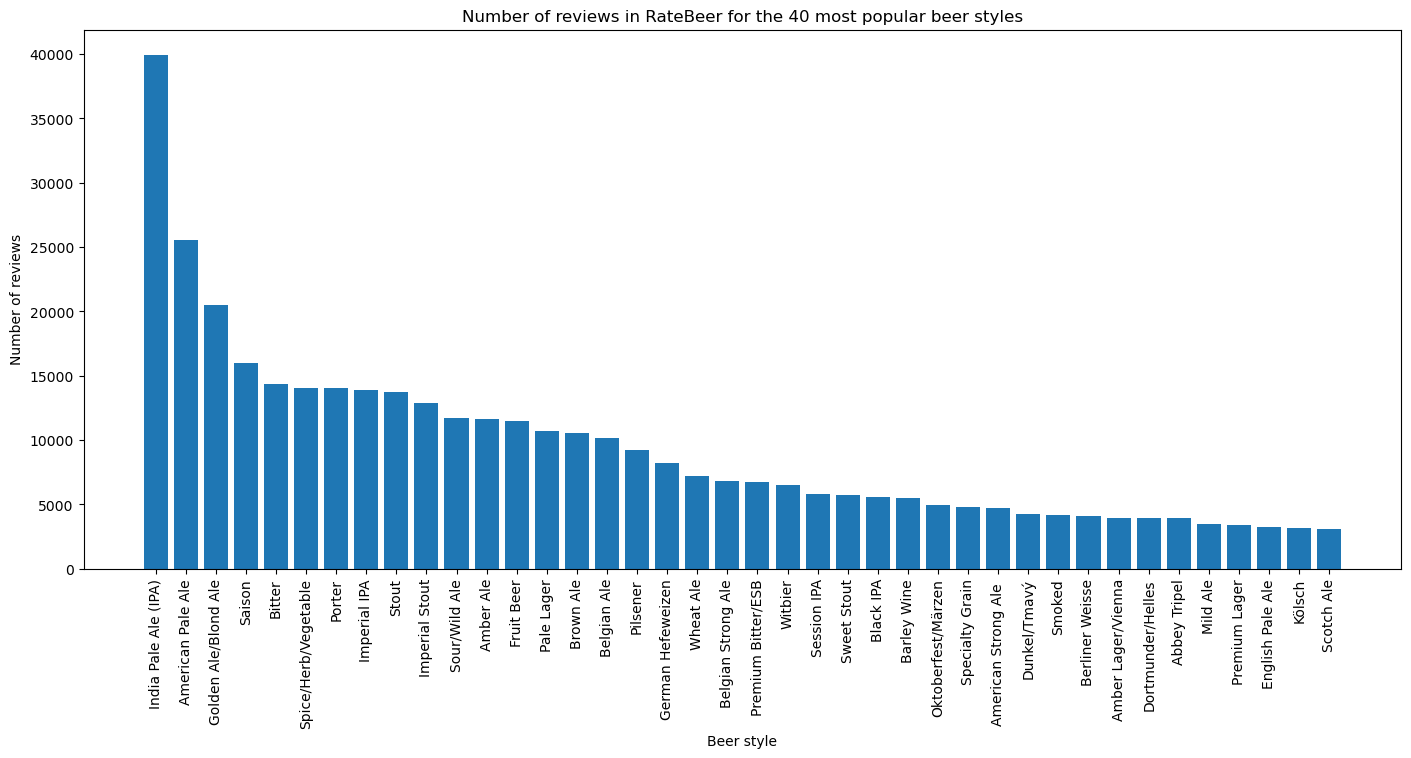

In [11]:
beers_RB = pd.read_csv(os.path.join(path_RB, 'beers.csv'))

top_40_styles_RB = beers_RB['style'].value_counts().head(40)

fig  = plt.figure(figsize=(17,7))
# plt.bar(beers_RB['style'].value_counts().index, beers_RB['style'].value_counts())
plt.bar(top_40_styles_RB.index, top_40_styles_RB.values)
plt.xticks(rotation=90)
plt.title('Number of reviews in RateBeer for the 40 most popular beer styles')
plt.ylabel('Number of reviews')
plt.xlabel('Beer style')
plt.show()

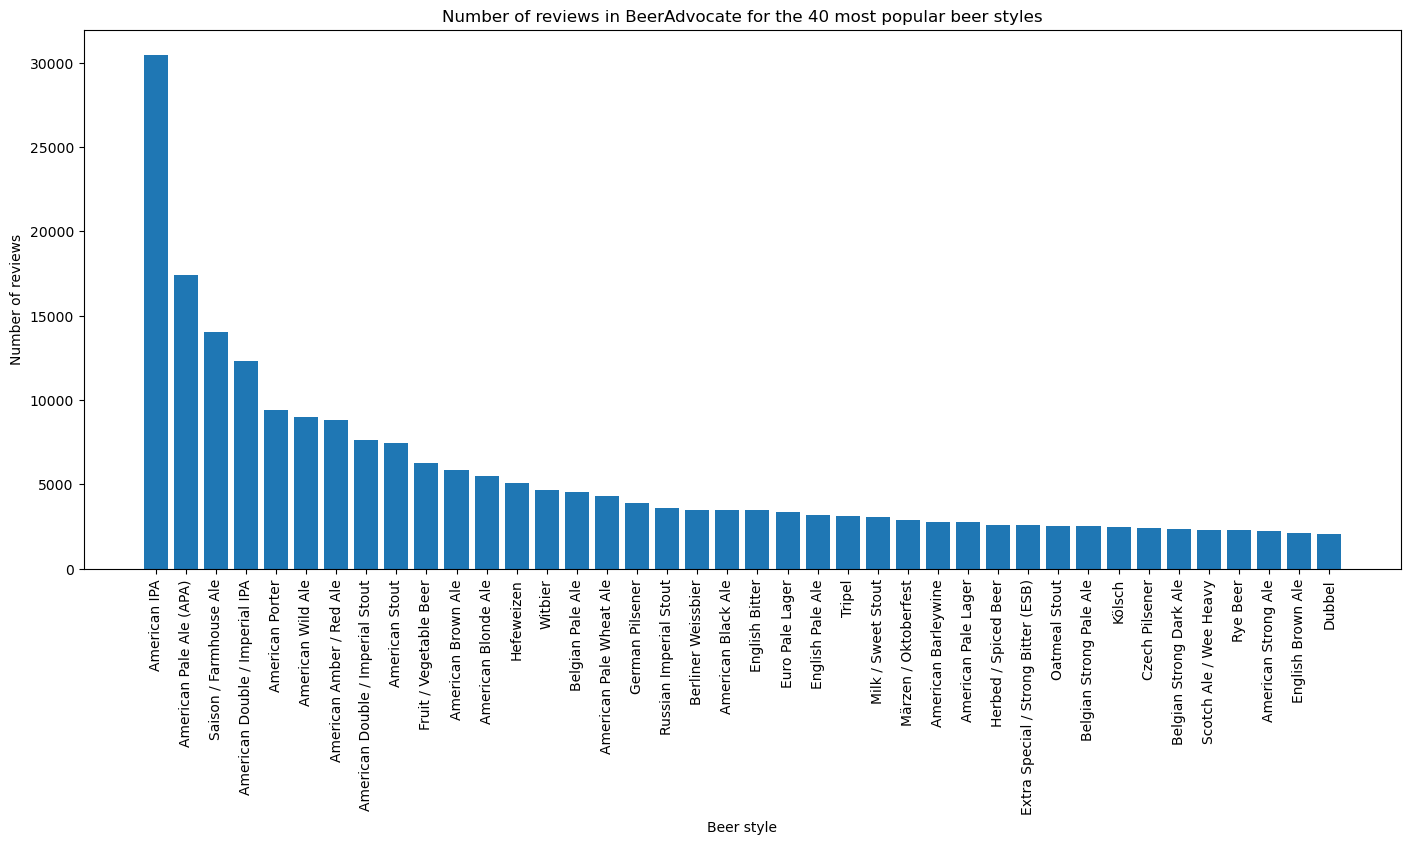

In [12]:
beers_BA = pd.read_csv(os.path.join(path_BA, 'beers.csv'))

top_40_styles_BA = beers_BA['style'].value_counts().head(40)

fig  = plt.figure(figsize=(17,7))
# plt.bar(beers_RB['style'].value_counts().index, beers_RB['style'].value_counts())
plt.bar(top_40_styles_BA.index, top_40_styles_BA.values)
plt.xticks(rotation=90)
plt.title('Number of reviews in BeerAdvocate for the 40 most popular beer styles')
plt.ylabel('Number of reviews')
plt.xlabel('Beer style')
plt.show()

It is particularly interesting to see the difference between the two datasets.
While RateBeer is a more "international" website, having reviews from many different countries, BeerAdvocate is primarily a North American website. As a consequence of this, BeerAdvocate has most reviews on American style beers, clearly evident from the plots.

#### Ratings correlation

Another interesting analysis can be conducted to see how the different characteristics of a beer impact in the final score of a beer.

In [13]:
ratings_RB = pd.read_csv(os.path.join(path_RB, 'ratings_RB.csv'))
ratings_BA = pd.read_csv(os.path.join(path_BA, 'ratings_BA.csv'))

Text(0.5, 1.0, 'BeerAdvocate')

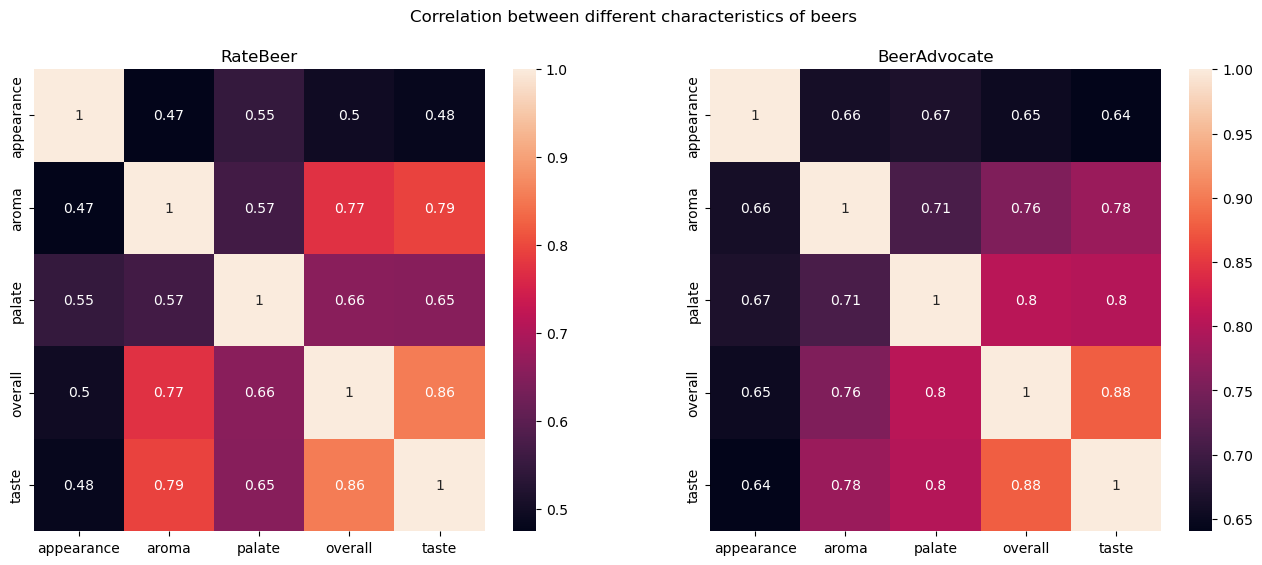

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Correlation between different characteristics of beers')

sns.heatmap(ratings_RB[['appearance', 'aroma', 'palate', 'overall', 'taste']].corr(), annot=True, ax=axes[0])
axes[0].set_title('RateBeer')

sns.heatmap(ratings_BA[['appearance', 'aroma', 'palate', 'overall', 'taste']].corr(), annot=True, ax=axes[1])
axes[1].set_title('BeerAdvocate')

It is noteworthy the correlation between the overall score and the taste of the given beer.

#### Peculiarity on the ratings

In RateBeer, a curious phenomen happens in the overall_score and style_score of the reviews.<br>
There are two peaks, one around 100 (max score) and one around 50.

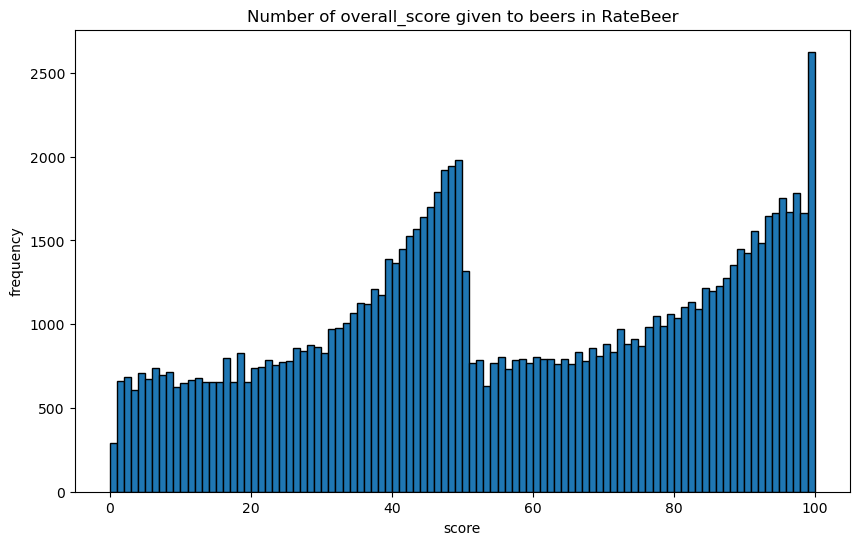

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(beers_RB['overall_score'], bins=100, edgecolor='black')
plt.title('Number of overall_score given to beers in RateBeer')
plt.ylabel('frequency')
plt.xlabel('score')
plt.show()

In [16]:
# Free memory after showing the results
del users_BA, users_RB, beers_RB, beers_BA, ratings_RB, ratings_BA

## Expert metric

The vast majority of the work done for the project has been finding a good "Expert metric" and checking that our assumptions are correct.

We needed a "Expert metric" that was reliable enough to see how written reviews change over time. This score should highlight the expertise and the precision of a review.

We tried different methods to get this metric:
- language depth
- embeddings
- ad-hoc metric

The first two didn't provide a significant score, while a "ad-hoc metric" proved to satisfy our needs. We therefore start by discussing this method.

### Ad-hoc metric

Due to the failure of previous general metrics, we tried creating a topic-specific metric that focuses solely on beer reviews.<br>

The goal is to develop a domain-specific metric. In this initial implementation, we define several key categories: flavor, mouthfeel, brewing, technical aspects, appearance and off-flavors. Each category contains specific terms relevant to beer evaluation. For every occurrence of these terms in a review, we add a point to the respective category score. The overall "expertness" score is calculated as the sum of these category scores. To account for the fact that different beers may have varying average scores due to distinct flavor profiles, each score is normalized using the mean and standard deviation of scores for the specific beer being reviewed. This approach aims to establish a consistent and meaningful metric that reflects the depth and expertise conveyed in beer reviews.

In [ ]:
from src.scripts.expert_metric.exp_stem_extractor import *
from src.scripts.expert_metric.add_exp import *

data_folder = './data'
#
add_exp_stems(data_folder)
add_exp_scores(data_folder)

In [1]:
from src.scripts.expert_analysis.analysis_helper import *
from src.scripts.helpers import *

data_folder = './data'

exp_categories = get_exp_categories(data_folder) + ['expertness_score']
rev_with_scores_ba, beers_ba, users_ba, rev_with_scores_rb, beers_rb, users_rb = get_expert_metric_dfs(data_folder)

#### Expert words

In [ ]:
from src.scripts.word_occurences.word_cloud import *

word_occ = get_word_occ(rev_with_scores_ba, rev_with_scores_rb)

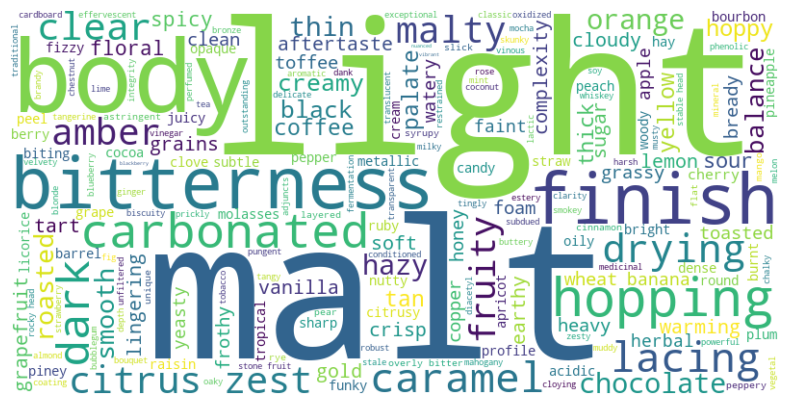

In [26]:
plot_word_cloud(data_folder, word_occ)

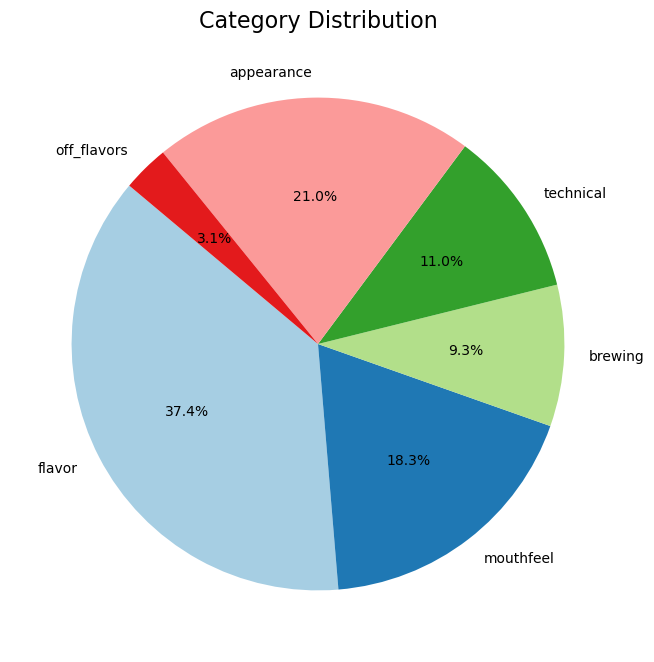

In [27]:
plot_word_category_distribution(data_folder, word_occ)

#### Score distribution

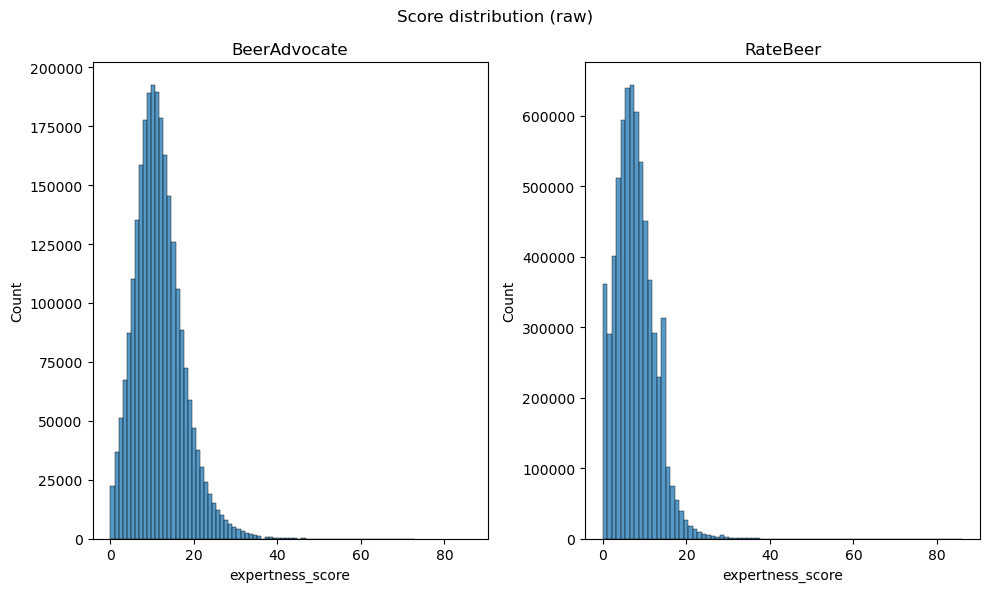

In [2]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True) 

fig.suptitle('Score distribution (raw)')
sns.histplot(rev_with_scores_ba.expertness_score, bins = 75, ax=axes[0])
axes[0].set_title("BeerAdvocate")
sns.histplot(rev_with_scores_rb.expertness_score, bins = 80, ax=axes[1])
axes[1].set_title("RateBeer")

plt.tight_layout()  
plt.show()


#### Log standardization of the scores

In [2]:
rev_std_ba = standardize_log(rev_with_scores_ba, exp_categories, by_style=True) 
rev_std_rb = standardize_log(rev_with_scores_rb, exp_categories, by_style=True) 

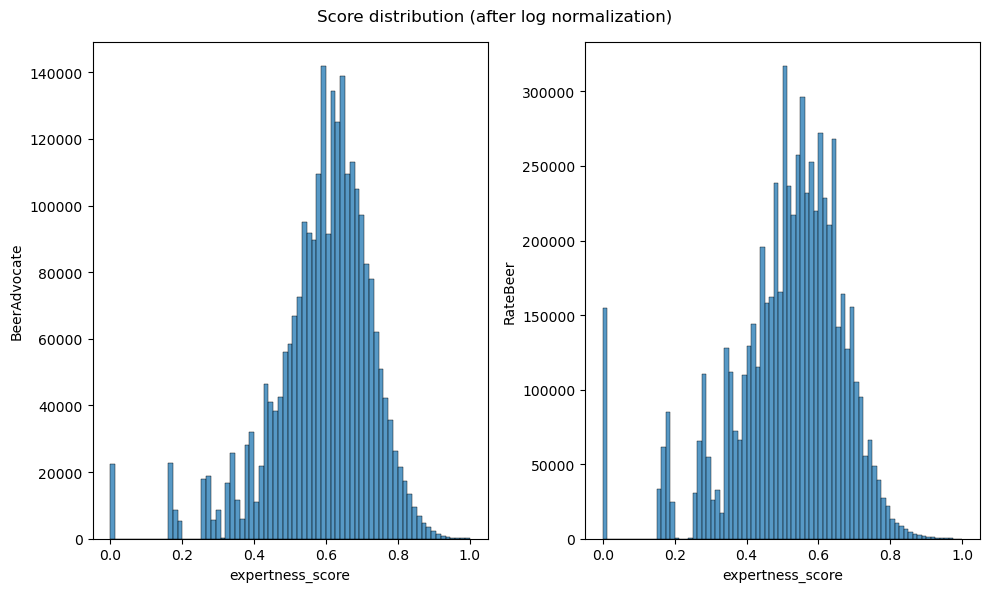

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True) 

fig.suptitle('Score distribution (after log normalization)')
sns.histplot(rev_std_ba.expertness_score, bins = 75, ax=axes[0])
axes[0].set_title("BeerAdvocate")
sns.histplot(rev_std_rb.expertness_score, bins = 80, ax=axes[1])
axes[1].set_title("RateBeer") 

plt.tight_layout()  
plt.show()

#### Evolution of scores for each category

From now on we will consider only reviews given by users that wrote at least five reviews 

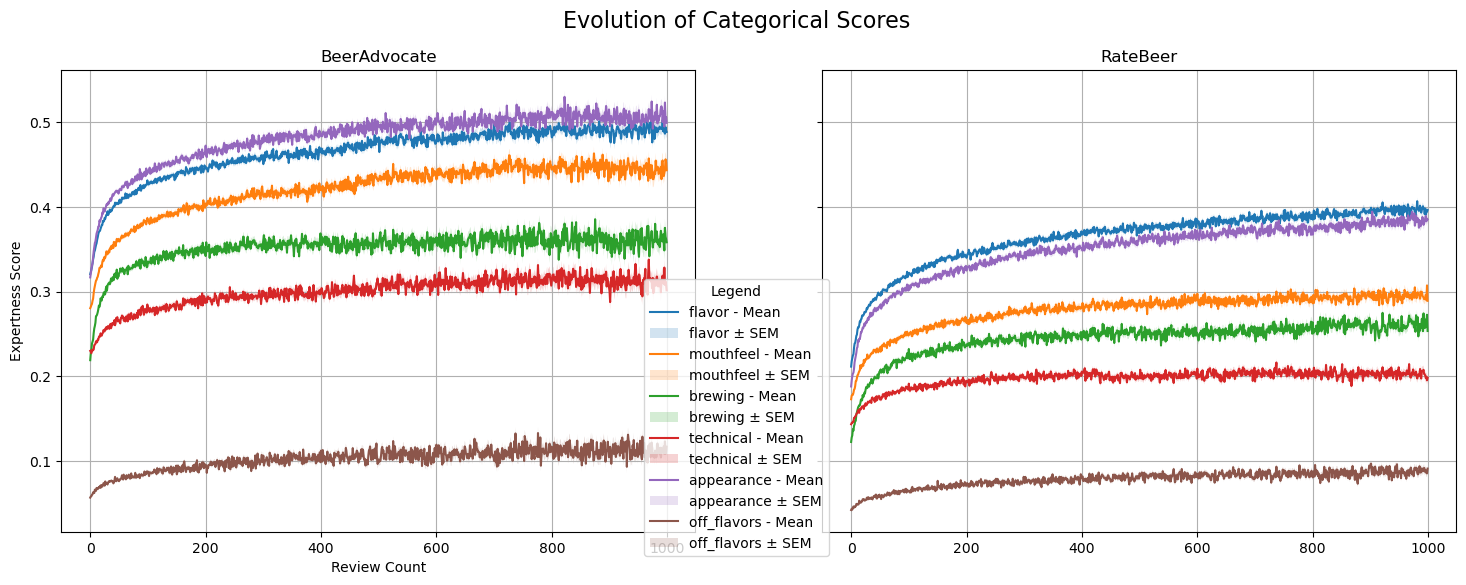

In [42]:
plot_categorical_evolution(rev_std_ba, rev_std_rb, users_ba, users_rb, exp_categories)

#### Analysis of the first reviews of each users

In [5]:
rev_first_gr_ba = get_first_rev_by_user(rev_std_ba, users_ba)
rev_first_gr_rb = get_first_rev_by_user(rev_std_rb, users_rb, user_id='user_name')

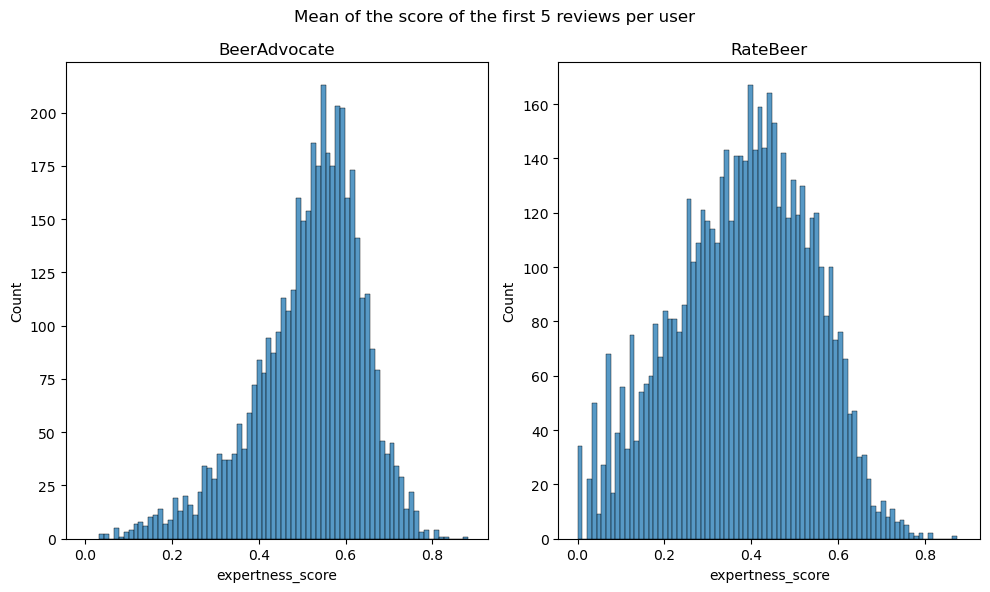

In [4]:
plot_first_rev_distribution(rev_first_gr_ba, rev_first_gr_rb)

This shows the average of the first reviews of each user from this we can know divede user in three categories: the average population, users that started with a score very low and already expert users. Could be interesting to analyze the evolution of this three category separated.

In [6]:
exp_levels_ba = get_exp_levels(rev_first_gr_ba)
exp_levels_rb = get_exp_levels(rev_first_gr_rb)

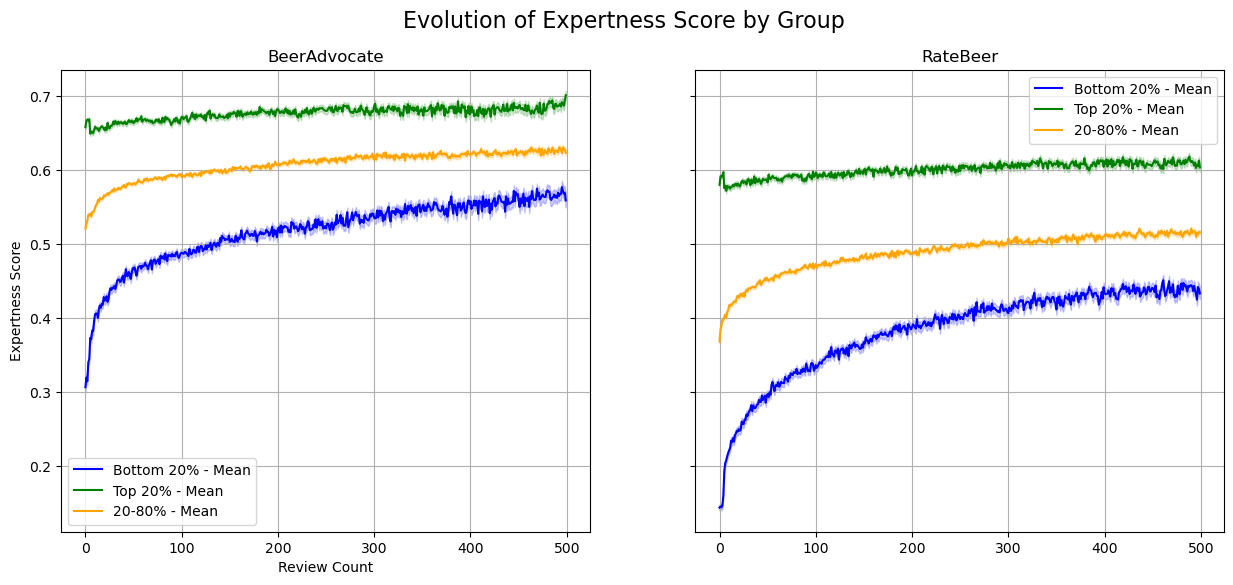

In [7]:
plot_exp_level_evolution(rev_std_ba, rev_std_rb, users_ba, users_rb, exp_levels_ba, exp_levels_rb, exp_categories, max_rev=500)

There is difference between the evolution of people coming from English speaking countries and the others

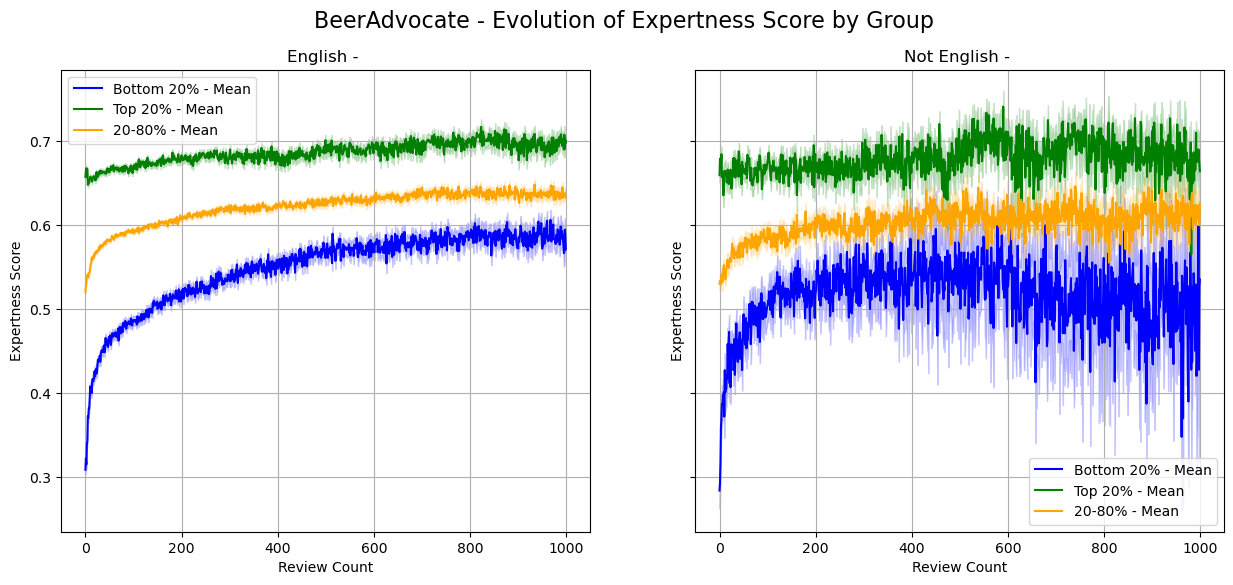

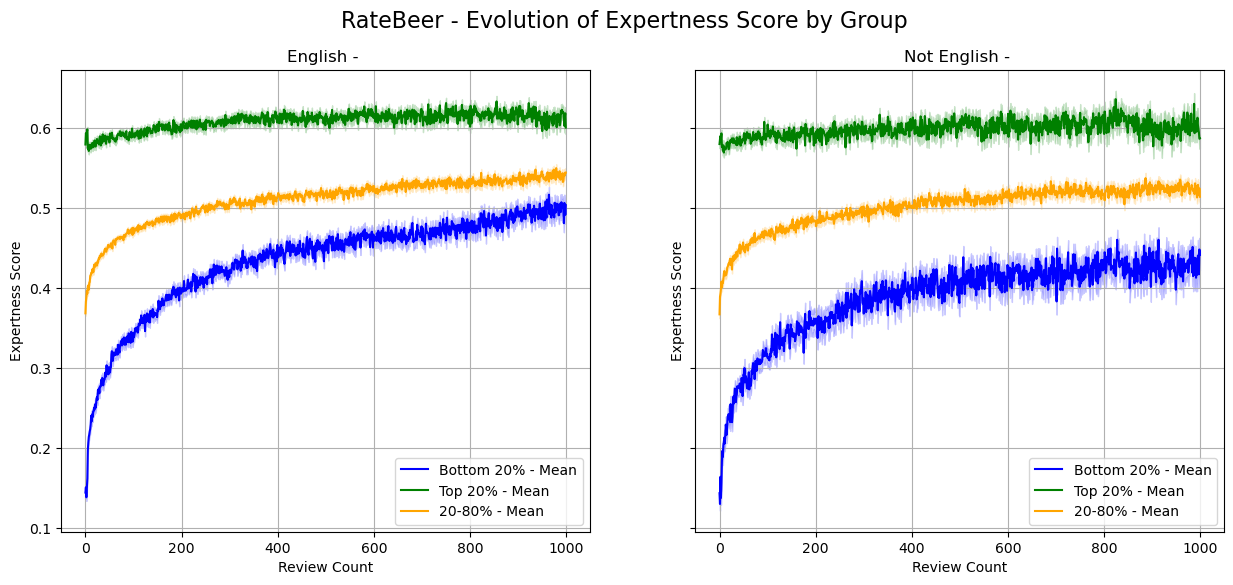

In [8]:
eng_countries = ['United States','Scotland', 'Ireland', 'England', 'Northern Ireland', 'Australia', 'Canada', 'New Zealand']
plot_exp_countries_evolution(rev_std_ba, users_ba, exp_levels_ba, exp_categories, eng_countries)
plot_exp_countries_evolution(rev_std_rb, users_rb, exp_levels_rb, exp_categories, eng_countries, user_id='user_name')

#### Correlation between review count and expertness score

In [8]:
at_least = 200
eval_until = 50
df_corr_ba = get_corr_df(rev_std_ba, users_ba, nbr_rev=eval_until, at_least=at_least)
df_corr_rb = get_corr_df(rev_std_rb, users_rb, user_id='user_name', nbr_rev=eval_until, at_least=at_least)

In [9]:
non_exp_stats_ba = df_corr_ba[df_corr_ba.index.isin(exp_levels_ba['Bottom 20%'])]
non_exp_stats_rb = df_corr_rb[df_corr_rb.index.isin(exp_levels_rb['Bottom 20%'])]

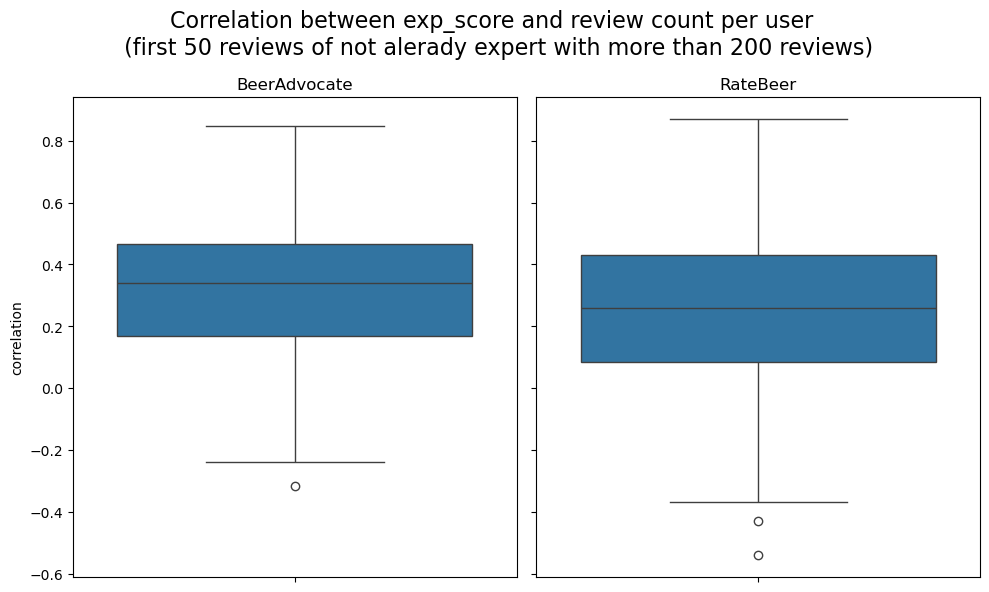

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True) 

fig.suptitle("Correlation between exp_score and review count per user \n (first %d reviews of not alerady expert with more than %d reviews)" %(eval_until, at_least), fontsize=16)
sns.boxplot(y=non_exp_stats_ba['correlation'], ax=axes[0])
axes[0].set_title("BeerAdvocate")
sns.boxplot(y=non_exp_stats_rb['correlation'],ax=axes[1])
axes[1].set_title("RateBeer") 

plt.tight_layout()  
plt.show()

In [16]:
print("                     BeerAdvocate     Ratebeer")
print("Median Correlation   %3f         %2f"%(non_exp_stats_ba['correlation'].median(), non_exp_stats_rb['correlation'].median()))
print("Median p-vaues       %3f         %2f" %(non_exp_stats_ba['p_value'].median(), non_exp_stats_rb['p_value'].median()))

                     BeerAdvocate     Ratebeer
Median Correlation   0.341160         0.259190
Median p-vaues       0.015327         0.060041


#### Raw score per style

In [9]:
beer_gr_ba = get_beer_gr(rev_with_scores_ba, beers_ba, exp_categories)
beer_gr_rb = get_beer_gr(rev_with_scores_rb, beers_rb, exp_categories)

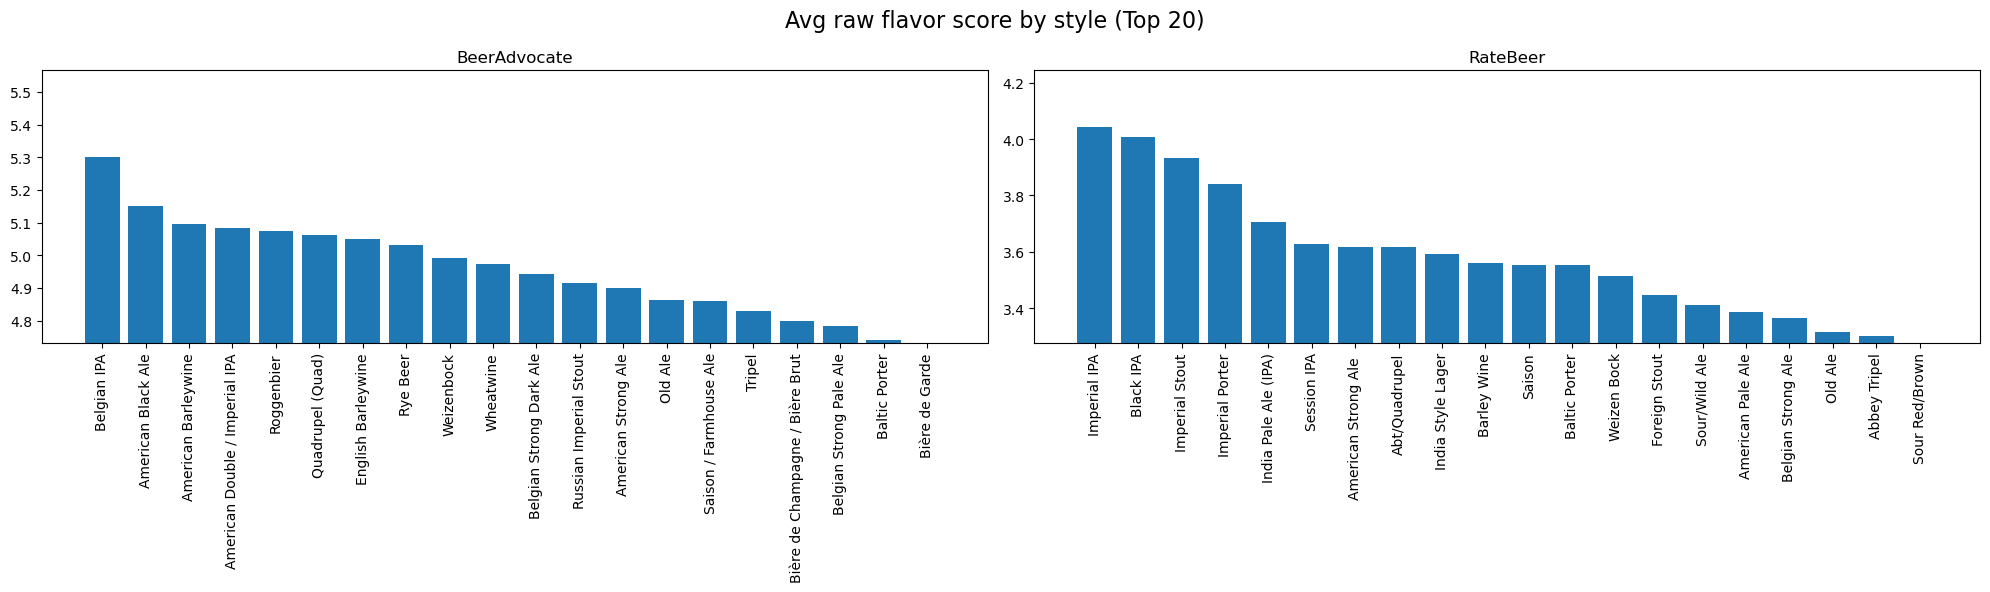

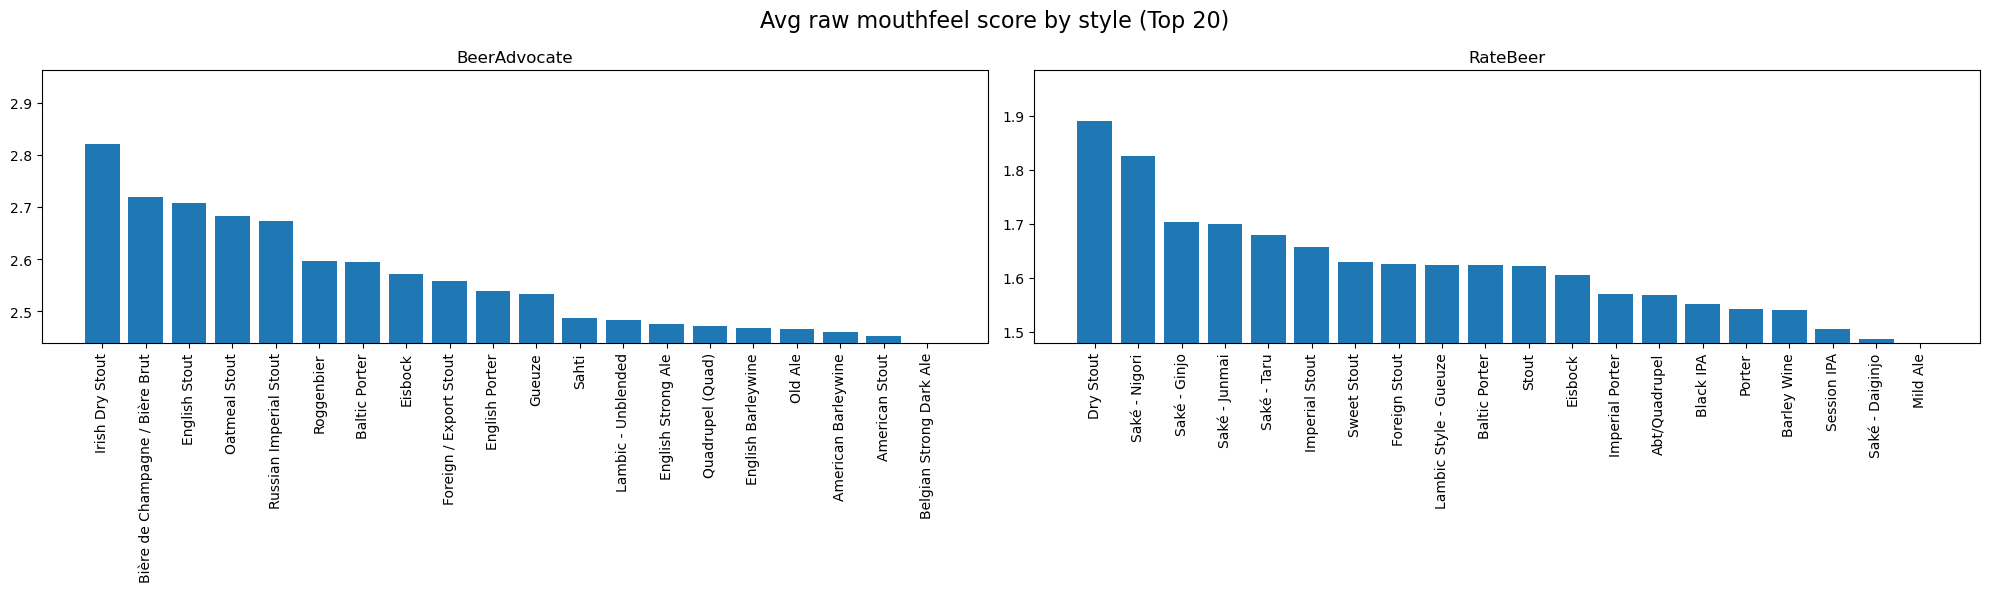

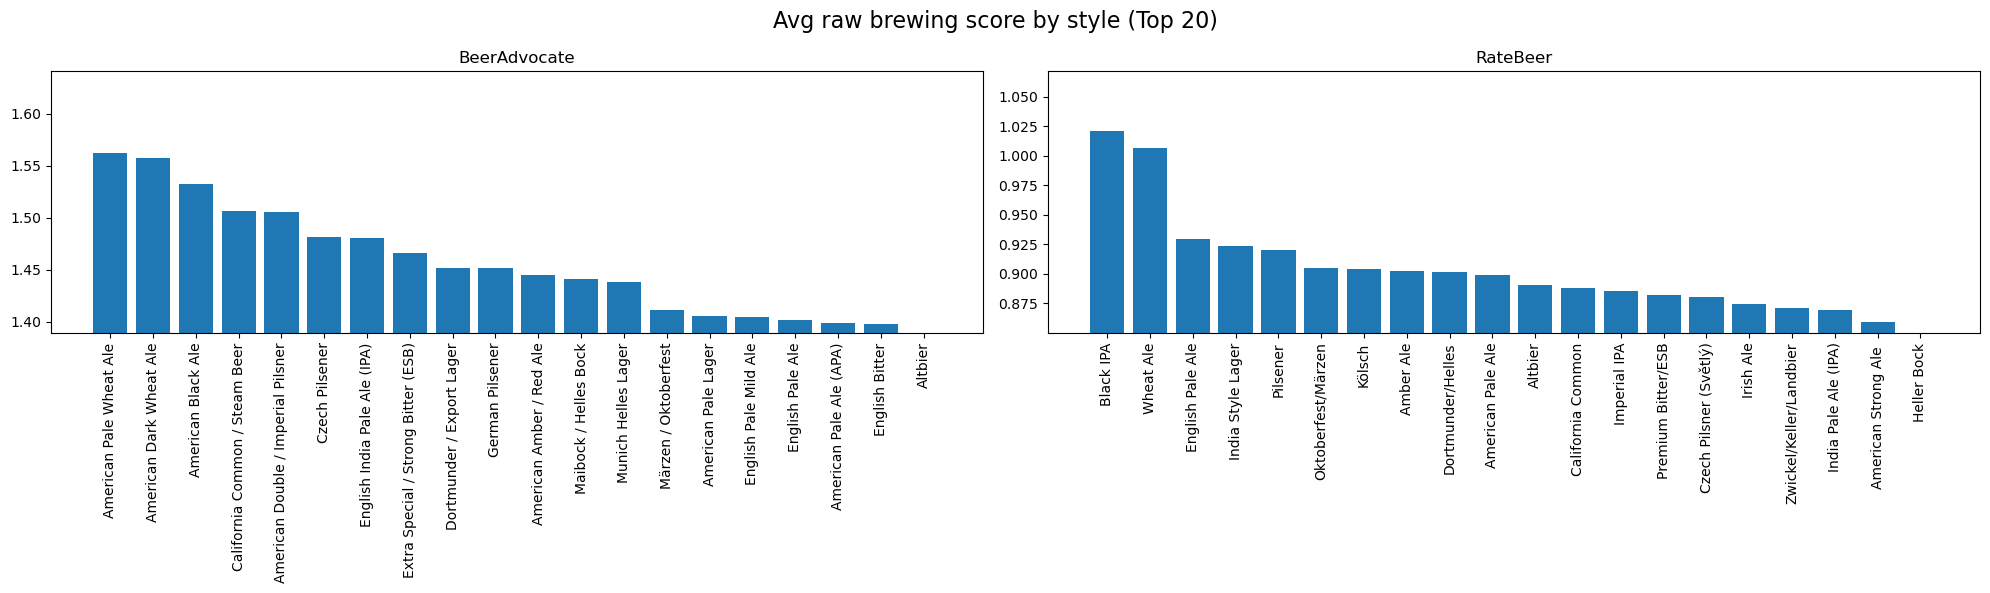

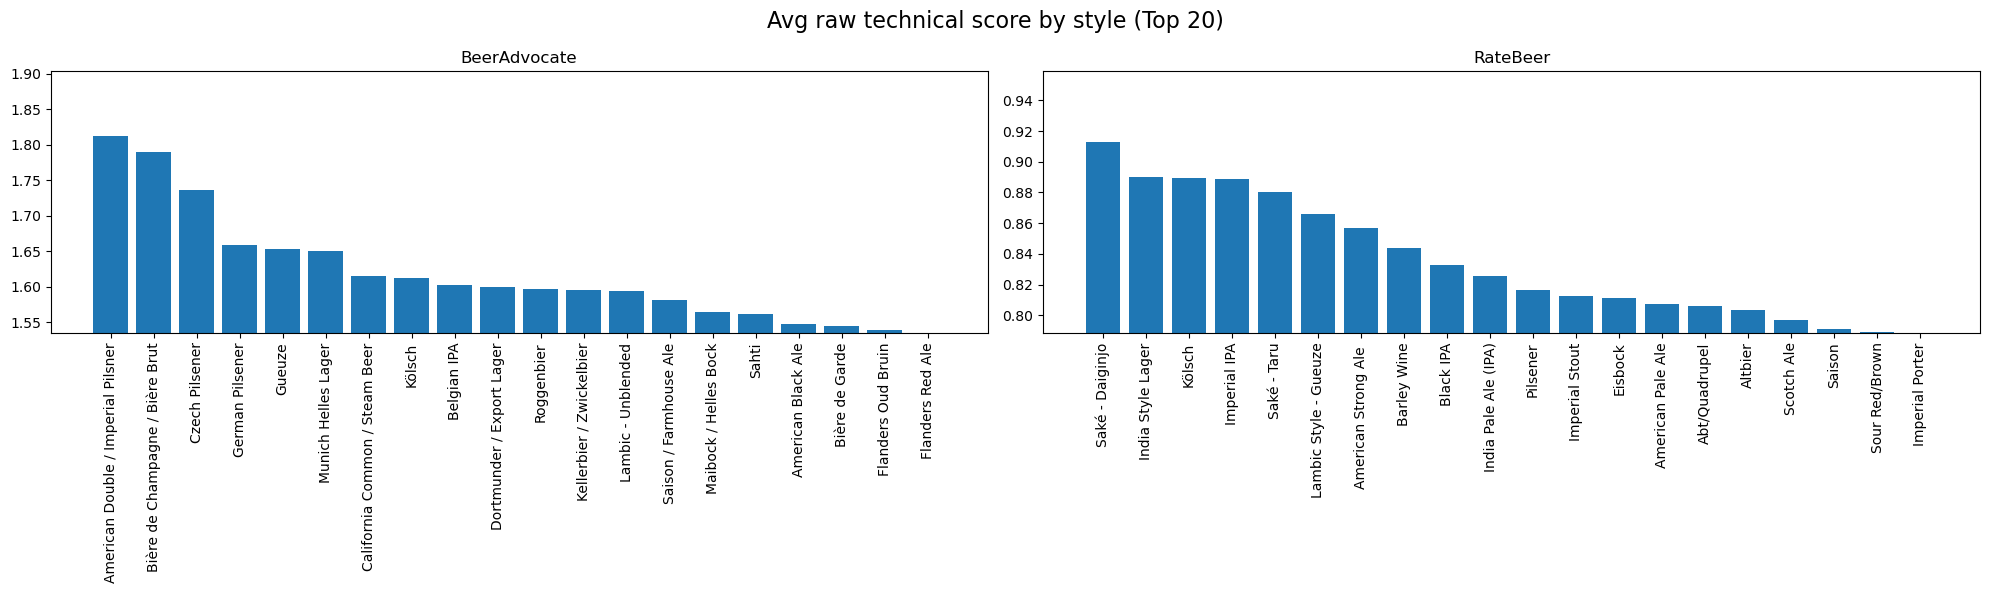

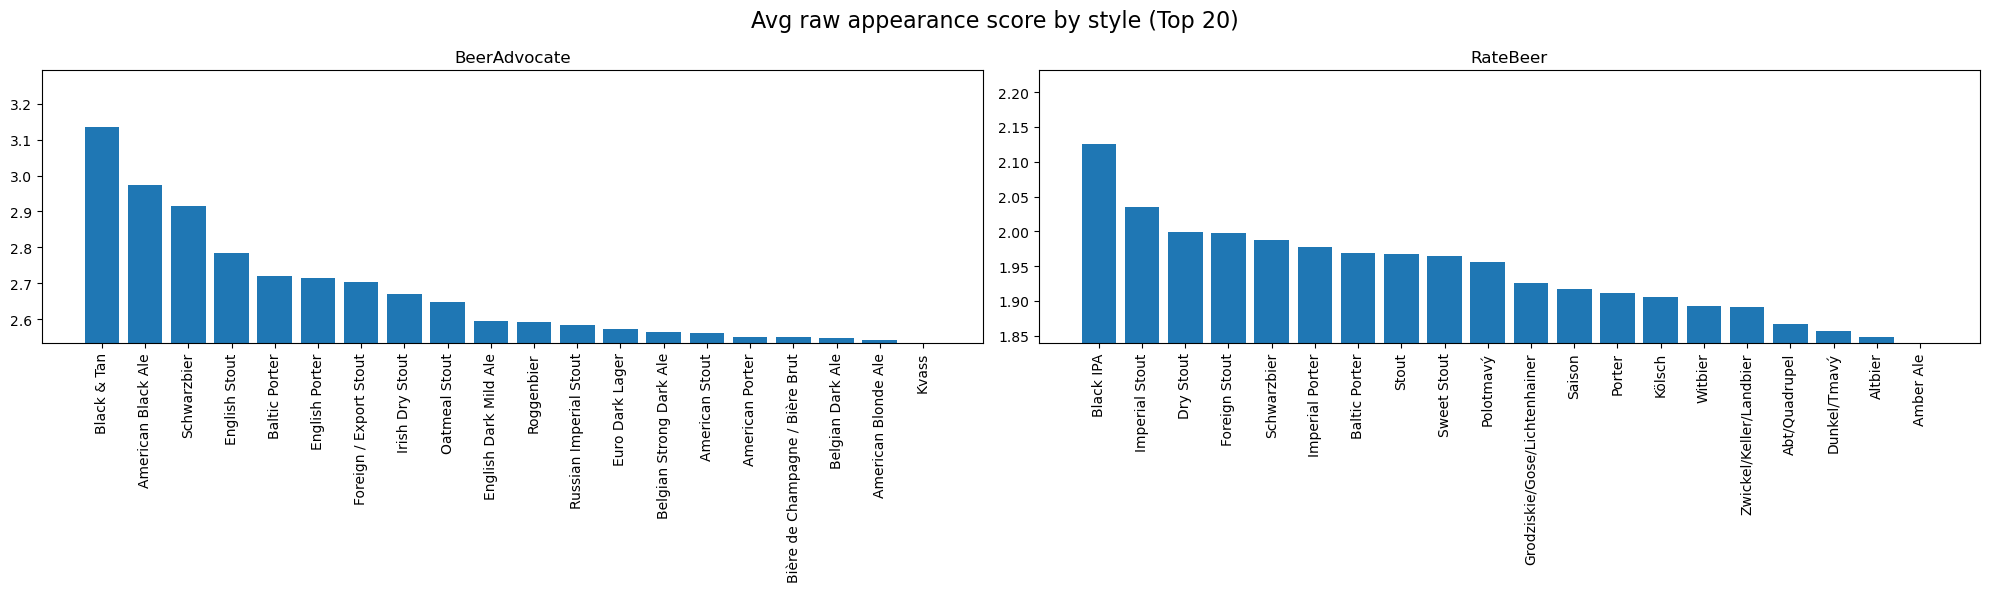

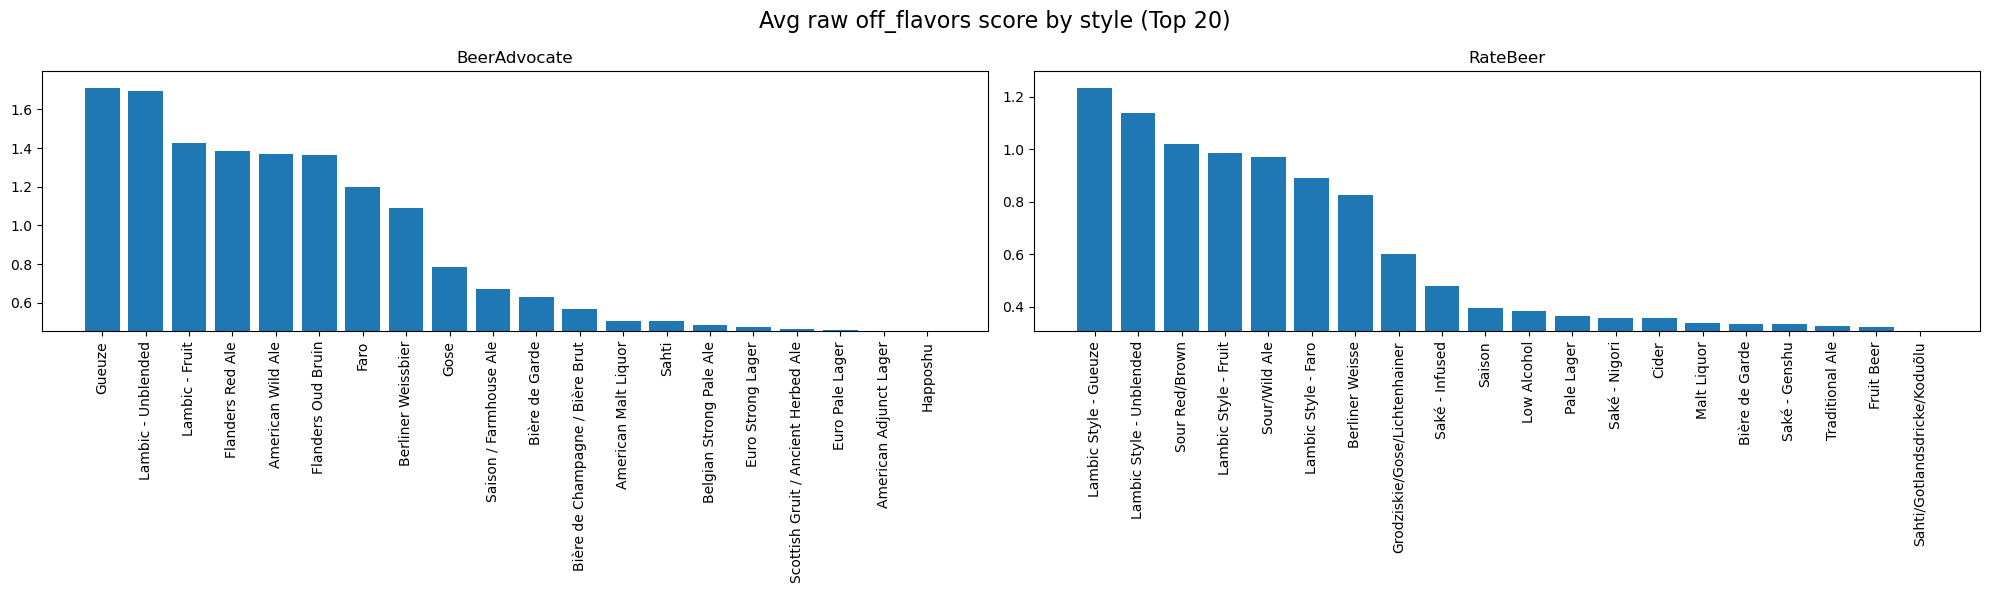

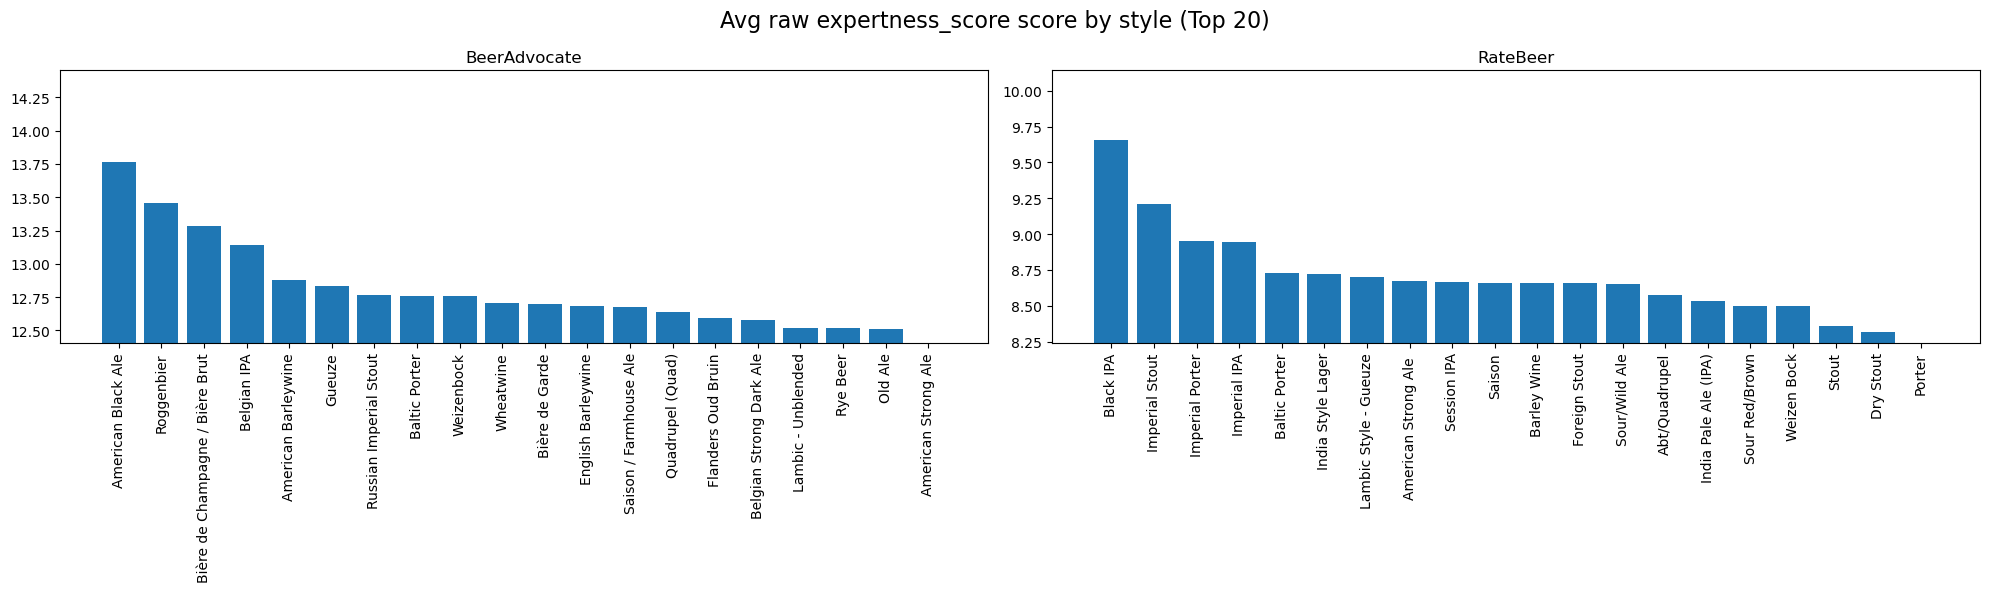

In [39]:
for col in exp_categories:    
    top_ = 20
    fig, axes = plt.subplots(1, 2, figsize=(20, 6)) 

    sorted_ba = beer_gr_ba[col].sort_values(ascending=False).head(top_)
    sorted_rb = beer_gr_rb[col].sort_values(ascending=False).head(top_)

    fig.suptitle("Avg raw %s score by style (Top %d)"%(col, top_), fontsize=16)
    axes[0].bar(sorted_ba.index, sorted_ba.values)
    axes[0].set_title("BeerAdvocate")
    axes[1].bar(sorted_rb.index, sorted_rb.values)
    axes[1].set_title("RateBeer") 

    axes[0].tick_params(axis='x', rotation=90) 
    axes[1].tick_params(axis='x', rotation=90)   

    axes[0].set_ylim(sorted_ba.values[-1])  # Replace with your desired range
    axes[1].set_ylim(sorted_rb.values[-1])


   
    plt.tight_layout()  
    plt.show()

#### Visualization of the difference between categorical score per style

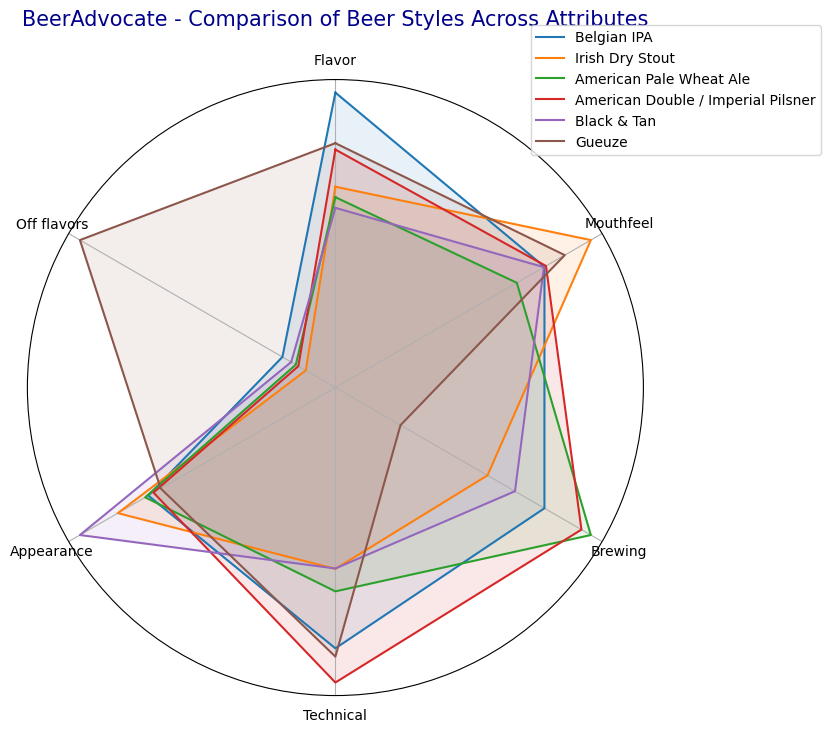

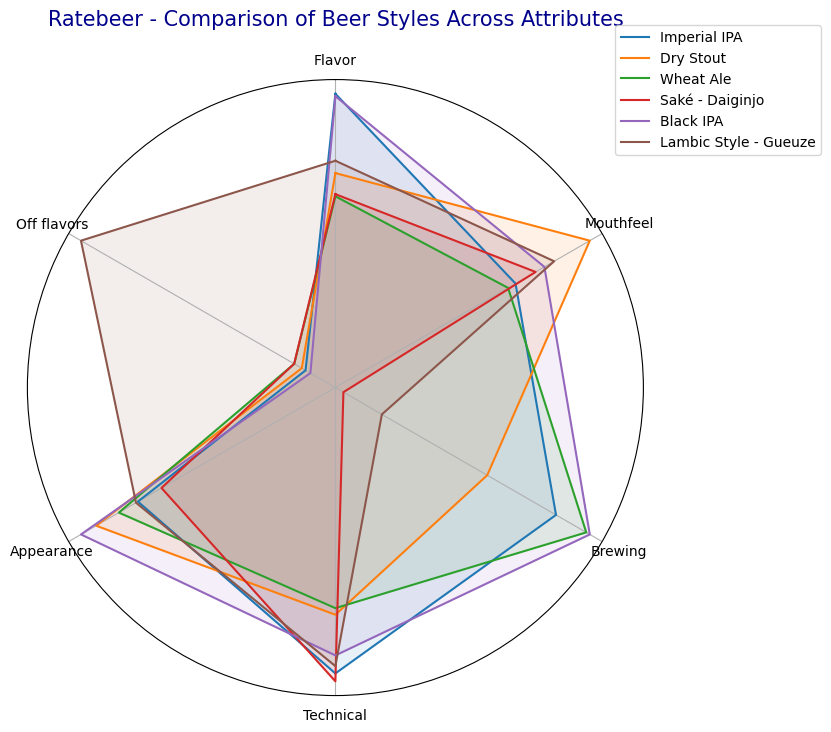

In [12]:
plot_cat_score_per_style(beer_gr_ba, beer_gr_rb, exp_categories)

### Previous part that I do not touch we can reuse some of the comments

A first assumption made is that with time, a user gets more experience and therefore can understand and describe better characteristics of the beers he reviews. This is shown by the positive correlation between time and our metric score.

In [18]:
user_corr = expert_analysis.parse_users(rev_with_scores)

# Correlation between the expertness score and the number of reviews made for all users
corr_all_users = pearsonr(user_corr['expertness_score'], user_corr['nbr_rev'])
# Correlation only for users that made less than 200 reviews
user_corr_less_200 = user_corr[user_corr['nbr_rev']<200]
corr_less_200_rev = pearsonr(user_corr_less_200['expertness_score'], user_corr_less_200['nbr_rev'])

print(f"Correlation between the expertness score and the number of reviews made for all users\n{corr_all_users}\n")
print(f"Correlation only for users that made less than 200 reviews\n{corr_less_200_rev}")

Correlation between the expertness score and the number of reviews made for all users
PearsonRResult(statistic=0.19585266685946312, pvalue=0.0)

Correlation only for users that made less than 200 reviews
PearsonRResult(statistic=0.25250688377961705, pvalue=0.0)


From those correlations, it seems that people with less reviews tent to improve (i.e. higher positive correlation) more than people who do more reviews.<br>
A further analysis revealed how for an expert the metric changes over time.

This particular example shows that our assumption can be true for some users.

We therefore focused on people that made a significant amount of reviews, i.e. at least 200, and tried to understand if such assumptions holds for a larger sample of users.

We start by showing that the first reviews that a user makes, tend to have a lower expertise score than average.<br>
To achieve this, we standardize the expert scores per beer.

In [20]:
col_to_keep = ['flavor', 'aroma', 'mouthfeel', 'brewing', 'technical', 'appearance', 'judgment','off_flavors', 'miscellaneous', 'expertness_score']

scores_for_beer = expert_analysis.get_scores_for_beer(rev_with_scores, col_to_keep)

/home/nicola_stocco/Documents/Università/ETH/3rd Semester/ADA/ada-2024-project-nada401/src/scripts/expert_metric/expert_analysis.py:83: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])


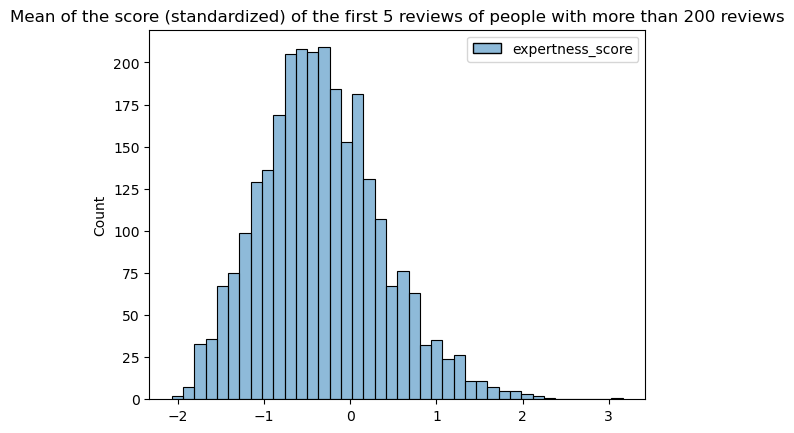

In [21]:
# Consider the first 5 reviews of people who did at least 200 reviews
rev_of_exp = expert_analysis.review_of_experts(rev_with_scores, users, nbr_rev=200)
rev_of_exp = expert_analysis.first_reviews(rev_of_exp, max=5)

# Standardize the expertise score on a per-beer basis
rev_exp_std = expert_analysis.standardize(rev_of_exp, scores_for_beer.reset_index(), col_to_keep)
rev_exp_std_grouped = rev_exp_std.groupby('user_id')[['expertness_score']].agg('mean')

# Plot results
sns.histplot(rev_exp_std_grouped)
plt.title('Mean of the score (standardized) of the first 5 reviews of people with more than 200 reviews')

# Consider as not already experts the users which have low scores on their first reviews 
no_already_experts = rev_exp_std_grouped[rev_exp_std_grouped['expertness_score']<-0.5].index

We now graphically show the correlation between the expert metric and the number of reviews that a user did. A positive correlation corresponds to an improvement over time of the expertise in the reviews that a user make.

In [22]:
# Consider the first 100 reviews of people who did at least 200 reviews
rev_of_exp = expert_analysis.review_of_experts(rev_with_scores, users, nbr_rev=200)
rev_of_exp = expert_analysis.first_reviews(rev_of_exp, max=100)

rev_exp_std = expert_analysis.standardize(rev_of_exp, scores_for_beer.reset_index(), col_to_keep)
result_rep_date = rev_exp_std.groupby('user_id').apply(lambda group: expert_analysis.corr_and_count(group, replace_date=True), include_groups=False)
result_rep_date = result_rep_date.dropna()

/home/nicola_stocco/Documents/Università/ETH/3rd Semester/ADA/ada-2024-project-nada401/src/scripts/expert_metric/expert_analysis.py:83: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])


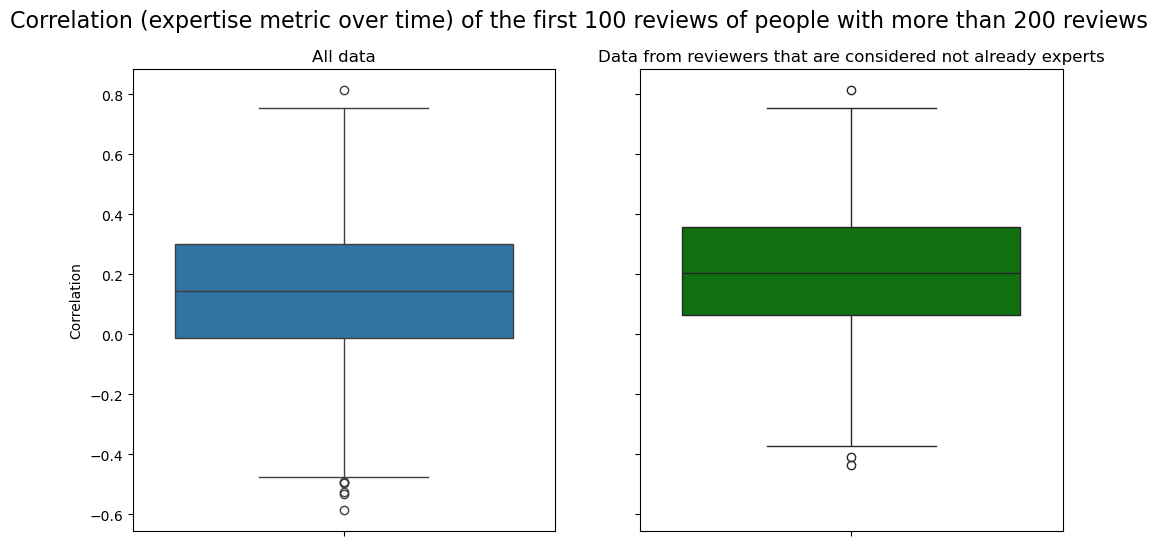

In [23]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey = True) 
fig.suptitle("Correlation (expertise metric over time) of the first 100 reviews of people with more than 200 reviews \n", fontsize=16)
sns.boxplot(y=result_rep_date['correlation'], ax=axes[0])
axes[0].set_title("All data")
axes[0].set_ylabel("Correlation")

sns.boxplot(y=result_rep_date[result_rep_date.index.isin(no_already_experts)]['correlation'], ax=axes[1], color = 'green')
axes[1].set_title("Data from reviewers that are considered not already experts")
plt.show()

This shows that reviewers with a lower then average score on their first reviews tend to improve in the next reviews.

In [24]:
# Clear memory after showing the results
del rev_with_scores, beers, users, user_corr, user_corr_less_200, rev_of_exp, rev_exp_std, rev_exp_std_grouped, sorted_data, scores_for_beer, result_rep_date

### Semantic Richness

Our initial approach was to use well-known NLP methods to quantify the language level used in the review. This method assumes that more experienced reviewers use a more nuanced and diverse vocabulary. We reviewed the literature to select the most commonly used metrics and we settled on HD-D and MTLD as recommended by [Y. Bestgen](https://onlinelibrary.wiley.com/doi/full/10.1111/lang.12630) and by [Text Inspector](https://textinspector.com/help/lexical-diversity/) (note that HD-D with parameter 42 is equivalent to vocd-D). We used the implementations provided by the
[LexicalRichness python package](https://github.com/LSYS/LexicalRichness).

However, the analysis yielded unsatisfactory results. We believe this is due to the combination of two factors:
- The metrics computed by the package are not specifically tailored to reviews or beer.
- The texts seen in BeerAdvocate reviews are comparatively short, concise and vocabulary-rich.

We will briefly showcase the aforementioned unsatisfactory results. The qualitative analysis yielded unsatisfactory results for both metrics, which appeared to perform similarly. The following review received one of the lowest HD-D scores, at 0.676:
>An orange, golden beer with an initial big head.The smell is hoppy with a nice herbal and noble hop aroma. The malt gives the beer a slight dextrinous smell that balances the yeast character of the saison yeast, which has a cork-like, stale smell. The taste is quite bitter with the noble hops giving the beer a pilsner like taste. The beer is dry which totally offers a different balance to the beer. The yeast gives the cellar, corky and dry taste distinct for a saison yeast. The dryness of the beer is a bit off balancing the beer and makes the beer a bit less interesting.

On the other hand, here is one of the highest rated reviews, with a 0.988:
>Thanks to El Nopalero for sharing this one. Orange amber, slightly hazy. It is not as dark as most quadruples. Low carbonation but big bubbles. Smells like alcohol, raisons and cherry. There was a lot going on with the taste: cherries, rum punch, notes of chocolate, Asian plum sauce, chocolaty graham cracker aftertaste, slight metallic finish. I’ll have another.

This highlights one of the issues with these metrics, which reward extremely concise and diverse text (the second review shown above is mostly a long list of technical terms). Moreover, even the lower ranked reviews of the dataset seem to have quite rich language. Nonetheless, we decided to explore whether these metrics could reveal any interesting relationships. However, we consistently observed low correlation values and high p-values.

### Embeddings

We also tried with finding the embeddings of the reviews and trying to see if such a method could be used as an expertise metric.<br>
To find the embeddings we used:
- [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) 

This model maps paragraphs to a 768 dimensional dense vector space, that we then visualize by projecting it in a 2D space with t-SNE and PCA.

While some interesting patterns have been observed, it is clear that embeddings can't be used as a metric score.

In the following graphs it is shown a projection of the embedding in the 2D space of the reviews of a specific beer (id=11757).<br>
The notebook used to get those plots can be found at:

`./src/scripts/embedding/embedding_work.ipynb`

![Embedding_output.png](./src/scripts/embedding/Embedding_output.png)